In [1]:
%matplotlib inline

import pickle
import warnings
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import beta, uniform, expon, lognorm, weibull_min, chi2, t, gumbel_r, skewnorm

from src.learner import LinearMDCRL
from experiments.rand import rand_model

warnings.filterwarnings('ignore')

## Two domains, varying sample sizes

In [2]:
nsamples_list = [1000,2500,5000,10000,25000]
nexp = 100
measure = "ks-test"

model_specs = {
    "nr_doms": 2,
    "joint_idx": [0,1],
    "domain_spec_idx": [[2,3],[4,5]],
    "noise_rvs": [beta(2,3), expon(scale=0.1), skewnorm(a=6), gumbel_r, 
                  lognorm(s=1), weibull_min(c=2), chi2(df=6)],
    "sample_sizes":  None,
    "dims": [10,10],
    "graph_density": 0.75,
    "mixing_density": 0.9,
    "mixing_distribution": 'unif',  # unif or normal
    "two_pure_children": False
}

##### Collect all info in dict #####
info = {"results": dict(),
        "metadata": dict(
            nsamples_list=nsamples_list,
            nexp=nexp,
            measure=measure,
            model_specs=model_specs
            )
        }

In [3]:
def run_experiments(info):
    metadata = info["metadata"]
    nexp = metadata["nexp"]
    nsamples_list = metadata["nsamples_list"]
    for s_ix, n in enumerate(nsamples_list):
        print(n)
        for exp_ix in range(nexp):
            if not exp_ix%100:
                print(exp_ix)
            # Sample data
            m = info["metadata"]["model_specs"]
            m["sample_sizes"] = [n for _ in range(m["nr_doms"])]
            data, g, B_true = rand_model(m)

            # Fit model
            model = LinearMDCRL(measure=info["metadata"]["measure"])


            start_time = time()
            model.fit(data)
            time_spent = time() - start_time

            # Score output
            nr_joint = model.nr_joint
            if nr_joint <= len(m["joint_idx"]):
                error = model.score_only_joint_columns(B_true, len(m["joint_idx"]))
            else:
                error = None

            # Save results
            info["results"][(s_ix, exp_ix)] = dict(
                nr_joint = nr_joint,
                error = error,
                time_spent = time_spent
            )
    return info

In [4]:
info = run_experiments(info)

1000
0
2500
0
5000
0
10000
0
25000
0


In [5]:
# Save
filename = f"experiments/results/nr_doms={model_specs['nr_doms']}_measure={measure}.pkl"

with open(filename, "wb") as f:
    pickle.dump(info, f)

In [6]:
# Load
#with open(filename, "rb") as f:
#    info = pickle.load(f)

In [7]:
# Error rate (too many detections)
def get_statistics(info):
    metadata = info["metadata"]
    nexp = metadata["nexp"]
    nsamples_list = metadata["nsamples_list"]
    m = metadata["model_specs"]

    error_rate = np.zeros(len(nsamples_list))
    frobenius = np.zeros(len(nsamples_list))
    for s_ix, n in enumerate(nsamples_list):
        binary_errors = np.zeros(nexp)
        frobenius_errors = np.full(nexp, np.nan)
        for exp_ix in range(nexp):
            if info["results"][(s_ix, exp_ix)]["nr_joint"] > m["nr_doms"]:
                binary_errors[exp_ix] = 1
            else:
                frobenius_errors[exp_ix] = info["results"][(s_ix, exp_ix)]["error"]
        error_rate[s_ix] = binary_errors.mean()
        frobenius[s_ix] = np.nanmedian(frobenius_errors)
    return (error_rate, frobenius)

In [8]:
error_rate, frobenius = get_statistics(info)

In [9]:
error_rate

array([0.53, 0.49, 0.1 , 0.  , 0.  ])

In [10]:
frobenius

array([0.55651259, 0.26727451, 0.19177922, 0.14661453, 0.08440931])

In [11]:
def plot_error_rate(nsamples_list, error_rate):
    sns.set()
    #plt.style.use("style.mplstyle")

    plt.clf()
    plt.plot(nsamples_list, error_rate)
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Error rate (too many detections)")
    plt.tight_layout()
    plt.show()

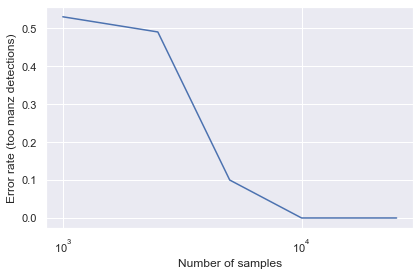

In [12]:
plot_error_rate(nsamples_list, error_rate)

In [13]:
def plot_frobenius(nsamples_list, frobenius):
    sns.set()
    #plt.style.use("style.mplstyle")

    plt.clf()
    plt.plot(nsamples_list, frobenius)
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Median frobenius error joint columns")
    plt.tight_layout()
    plt.show()

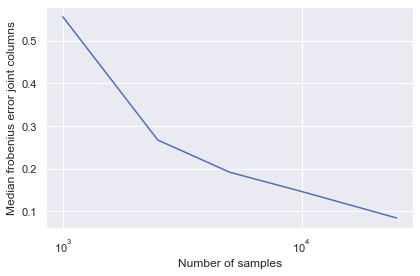

In [14]:
plot_frobenius(nsamples_list, frobenius)

## Three domains

In [15]:
nsamples_list = [1000,2500,5000,10000,25000]
nexp = 100
measure = "ks-test"

model_specs = {
    "nr_doms": 3,
    "joint_idx": [0,1],
    "domain_spec_idx": [[2,3],[4,5],[6]],
    "noise_rvs": [beta(2,3), expon(scale=0.1), skewnorm(a=6), gumbel_r, 
                  lognorm(s=1), weibull_min(c=2), chi2(df=6)],
    "sample_sizes":  None,
    "dims": [10,10,10],
    "graph_density": 0.75,
    "mixing_density": 0.9,
    "mixing_distribution": 'unif',  # unif or normal
    "two_pure_children": False
}

##### Collect all info in dict #####
info = {"results": dict(),
        "metadata": dict(
            nsamples_list=nsamples_list,
            nexp=nexp,
            measure=measure,
            model_specs=model_specs
            )
        }

In [16]:
info = run_experiments(info)

1000
0
2500
0
5000
0
10000
0
25000
0


In [17]:
error_rate, frobenius = get_statistics(info)

In [18]:
# Save
filename = f"experiments/results/nr_doms={model_specs['nr_doms']}_measure={measure}.pkl"

with open(filename, "wb") as f:
    pickle.dump(info, f)

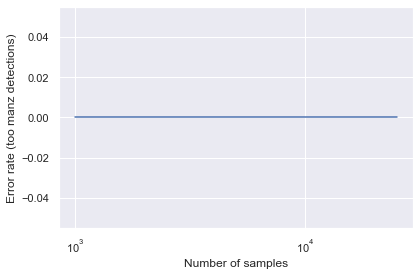

In [19]:
plot_error_rate(nsamples_list, error_rate)

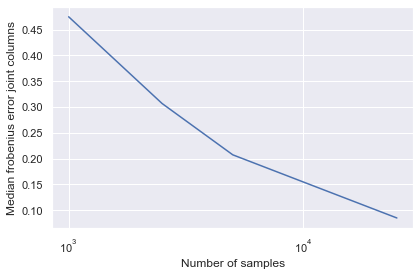

In [20]:
plot_frobenius(nsamples_list, frobenius)